Nonlinear feedforward+feedback guidance for SRP applications

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-whitegrid')

from Utils.gpops import srp as srp_opt
from Utils.RK4 import RK4 
from EntryGuidance.TrajPlot import TrajPlot

Nominal trajectory design via optimal control

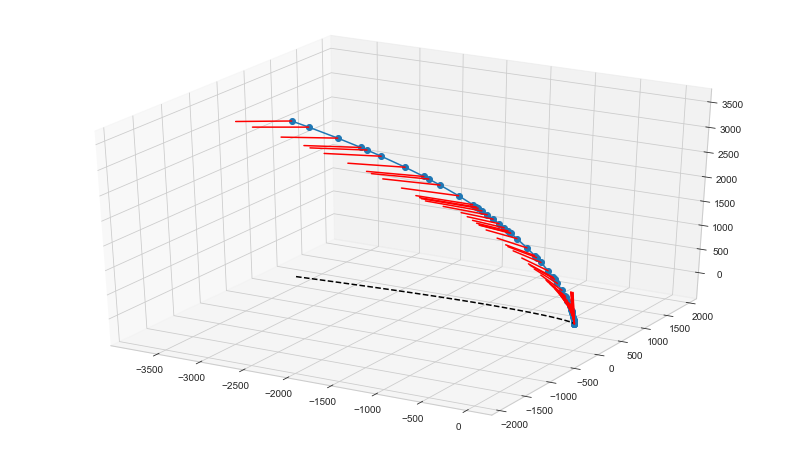

In [2]:
x0 = [-3200., 0., 3200., 625., 60., -270., 8500.]
traj = srp_opt((x0,))
# print((traj['time'][-1]))
u = np.array(traj['control']).T
plt.figure(1, figsize=(14,8))
TrajPlot(*(np.array(traj['state'])[:,0:3].T), T=(u[0]*u[1:4]).T/1000 , show=True, figNum=1)

Create a closed loop simulation from a given initial condition and for dispersed values of the model parameters

In [22]:
from scipy.interpolate import interp1d 

class SRPController:
    """ Manages the reference trajectory, gains, and differential states
    required to implement a nonlinear controller that is robust to uncertainty 
    """
    def __init__(self, reference, gains):
        u = np.array(reference['control']).T # Magnitude and unit vector representation         
        T = (u[0]*u[1:4]).T
        
        x = np.array(reference['state'])
        t = np.array(reference['time']).squeeze()
        
        self.reference_state = interp1d(t, x, axis=0, kind='cubic')
        self.reference_control = interp1d(t, T, axis=0, kind='cubic')
        self.gains = gains 
        
        self.gain_state = None
        self.gain_rate = None 
        self.gain_time = 0. 
        return 
        
        
    def controller(self, time, state, thrust_bounds):
        
        c, k, alpha, beta = self.gains # all gains could be a triple (per axis) but for now we'll assume scalars 
        
        ref_state = self.reference_state(time)
        ref_control = self.reference_control(time)
    
        ds = ref_state - state
        e1 = ds[0:3]
        e1_dot = ds[3:6]
        e = e1 + c*e1_dot 
#         K = np.diag(k)
        
        if self.gain_state is None:
            self.gain_state = np.zeros((3,))
            self.gain_rate = k*alpha*e + beta*np.sign(e)
            self.e0 = e 
        
#         self.gain_rate = k*alpha*e + beta*np.sign(e) # This is the current gain_rate. 
        self.gain_rate = 0.5*(self.gain_rate + k*alpha*e + beta*np.sign(e))  #We could also average it with the previous gain rate 
        self.gain_state += self.gain_rate * (time-self.gain_time)
        self.gain_time = time
    
        T = ref_control + k*(e-self.e0) + self.gain_state 
        
        # Clip the total magnitude to be within the bounds 
        Tmag = np.linalg.norm(T)
        Tunit = T/Tmag 
        T = np.clip(Tmag, *thrust_bounds) * Tunit 
        return T

def dynamics( x, t, u, vei):
        
        p = x[0:3]
        v = x[3:6] 
        m = x[6]
        
        g = np.array([0, 0, 3.71])
        if x.ndim>1:
            g = g[:,None]
        dx = np.empty(x.shape, dtype=x.dtype)     
        dx[0:3] = v
        dx[3:6] = u/m - g
        dx[6] = -vei * (u[0]**2 + u[1]**2 + u[2]**2)**0.5   
        return dx
    
def simulation(x0, tf, controller, param=(1./(9.81*290), 40*8500., 70*8500.), cycle=1):
    vei, Tmin, Tmax = param # Inverse escape velocity, min thrust, max thrust 

#     cycle = 1 # seconds 
    tf_int = int(tf)
    t = np.linspace(0, tf_int, tf_int/cycle)
    t = np.append(t, tf)
    dt = np.diff(t)
    
    X = [x0]
    U = []
    for time, next_time in zip(t, t[1:]):
        u = controller(time, X[-1], (Tmin, Tmax))
        U.append(u)
        
        x = RK4(dynamics, X[-1], np.linspace(time, next_time, 10), args=(u, vei))
        X.append(x[-1])
        
    U.append(U[-1]) # So its the same length 
#     controller.gain_state = None # essentially resets the controller, allowing it to be used for another simulation without recreating 
    return t, np.array(X), np.array(U)
    
    
def plot(t, x, u, label=""):

        T = np.linalg.norm(u, axis=1)
    
        label = label
        
        plt.figure(1)
        plt.plot(t, x.T[-1], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        plt.legend()
        
        plt.figure(2)
        plt.plot(t, x.T[0:3].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        
        plt.figure(3)
        plt.plot(t, x.T[3:6].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.legend()
        
        plt.figure(4)
        plt.plot(t, T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        plt.legend()
        
#         plt.figure(5)
#         plt.plot(t, u, '--', label=label)
#         plt.xlabel('Time (s)')
#         plt.ylabel('Control Directions')
#         plt.legend()
        
        return
    


In [25]:
# x0_nom = [-3200., 0., 3200., 625., 60., -270., 8500.]
x0 = [-3000., 0., 3700., 625., 60., -300., 8500.]
tf = float(np.array(traj['time'])[-1])

C = SRPController(traj, gains=(5., 100., 0.6, 300.))

t,x,u = simulation(x0, tf, C.controller, cycle=0.1)

print(t.shape)
print(x.shape)
print(u.shape)

C:\Users\cdnoyes\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


(141,)
(141, 7)
(141, 3)


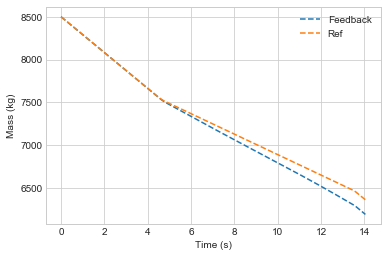

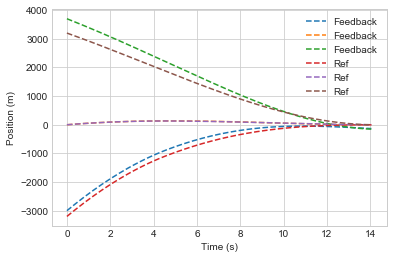

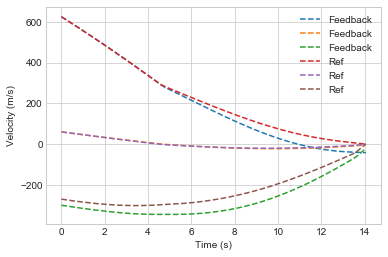

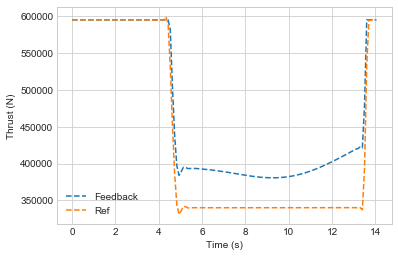

In [26]:
plot(t, x, u, label="Feedback")
plot(t, C.reference_state(t), C.reference_control(t), label="Ref")